# MNIST FPGA Implementation
Joash Naidoo

Tutorial on creating synthesizable FPGA code for classifying the Hello World of Neural Networks, the MNIST data set. Typically I enjoy implementing things from first principles however hls4ml requires Keras model (tensorflow backend), so that is what I'll be using.

This project was realized with the help of the following resources:

1. [Keras Tutorial](https://aigeekprogrammer.com/keras-python-mnist-handwritten-digit-recognition/)

2. [Keras API](https://keras.io/api/models/)

3. [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html)

4. [hls4ml](https://fastmachinelearning.org/hls4ml/)

5. [hls4ml Tutorial](https://keras.io/api/models/)

In [1]:
# Imports
import numpy as np
import tensorflow.keras

# Offers additional methods specific to MNIST dataset
from keras.datasets import mnist

/home/joash/miniconda3/envs/mnist_fpga/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/joash/miniconda3/envs/mnist_fpga/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/joash/miniconda3/envs/mnist_fpga/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/joash/miniconda3/envs/mnist_

In [2]:
# Load MNIST Data
(train_in, train_lbl), (test_in, test_lbl) = mnist.load_data()

In [3]:
# Normalize the data. Is required for synthesis later
train_in = train_in.astype("float32") / 255
test_in = test_in.astype("float32") / 255

# Flatten 28x28 2D image
train_in = train_in.reshape((-1, (28*28)))
test_in = test_in.reshape((-1, (28*28)))

In [4]:
# Create Model

# Adopting basic model from http://neuralnetworksanddeeplearning.com/chap1.html

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential ([
        Dense(30, activation='sigmoid', input_shape=(784,)), # input layer to 30 hidden
        Dense(10, activation='sigmoid') # 10 output
        #Dense(10, activation='sigmoid') # 10 ouput neurons
])

# Compile the model

model.compile(
    optimizer='SGD',
    loss='mean_squared_error',
    metrics=['accuracy']
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
# Train the model!

# Gives about a 91% accuracy. Not the main focus of this project

model.fit(
    x=train_in,
    y=tensorflow.keras.utils.to_categorical(train_lbl),
    epochs=30,
    batch_size=10,
    shuffle=True
)

Epoch 1/30
60000/60000 [==============================] - 7s 123us/sample - loss: 0.1008 - acc: 0.2542
Epoch 2/30
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0862 - acc: 0.3792
Epoch 3/30
60000/60000 [==============================] - 7s 122us/sample - loss: 0.0832 - acc: 0.4097
Epoch 4/30
60000/60000 [==============================] - 7s 117us/sample - loss: 0.0798 - acc: 0.4664
Epoch 5/30
60000/60000 [==============================] - 7s 114us/sample - loss: 0.0760 - acc: 0.5254
Epoch 6/30
60000/60000 [==============================] - 7s 117us/sample - loss: 0.0721 - acc: 0.5758
Epoch 7/30
60000/60000 [==============================] - 7s 115us/sample - loss: 0.0682 - acc: 0.6158
Epoch 8/30
60000/60000 [==============================] - 7s 116us/sample - loss: 0.0646 - acc: 0.6456
Epoch 9/30
60000/60000 [==============================] - 7s 119us/sample - loss: 0.0612 - acc: 0.6689
Epoch 10/30
60000/60000 [==============================] - 7s 123us/sampl

In [6]:
# Evaluate the model

eval = model.evaluate(test_in, tensorflow.keras.utils.to_categorical(test_lbl))
eval

10000/10000 [==============================] - 0s 30us/sample - loss: 0.0292 - acc: 0.8712


[0.029245713305473327, 0.8712]

## HLS4ML

In [7]:
import hls4ml

from keras.utils.vis_utils import plot_model

In [8]:
# Need a clearer idea what this is for

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
config

Interpreting Sequential
Topology:
Layer name: dense, layer type: Dense
  -> Activation (sigmoid), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (sigmoid), layer name: dense_1


{'Model': {'Precision': 'ap_fixed<16,6>',
  'ReuseFactor': 1,
  'Strategy': 'Latency'}}

In [9]:
# Building the model for Kintex7 KC705 Evaluation board

hls_model = hls4ml.converters.convert_from_keras_model(
                    model,
                    hls_config=config,
                    output_dir='model_1/hls4ml_prj',
                    fpga_part='xc7k325tffg900-2'
)

Interpreting Sequential
Input shape: [784]
Topology:
Layer name: dense, layer type: Dense, current shape: [[None, 784]]
Layer name: dense_1, layer type: Dense, current shape: [[None, 30]]
Creating HLS model


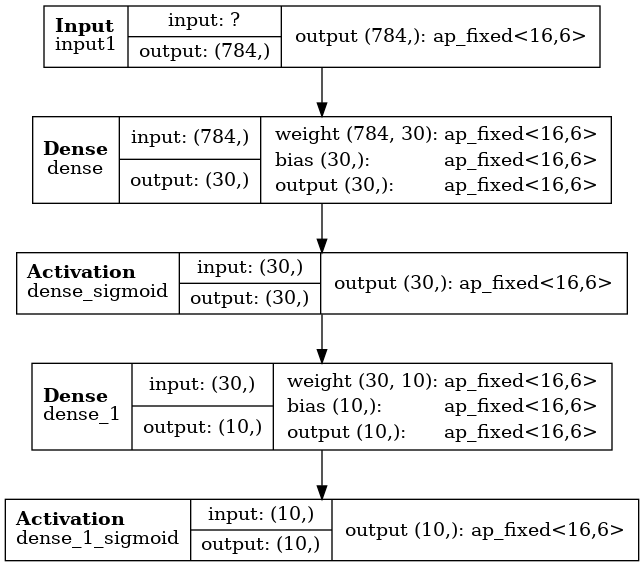

In [10]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [11]:
import os
# Add Vivado to PATH to Windows PATH
# os.environ['PATH'] += ';C:\\Xilinx\\Vivado\\2019.2\\bin\\unwrapped\\win64.o\\'
os.environ['PATH'] += ';/mnt/c/Xilinx/Vivado/2019.2/bin/unwrapped/win64.o'
print(os.environ['PATH'])


hls_model.compile()
hls_output = hls_model.predict(test_in)

/home/joash/miniconda3/envs/mnist_fpga/bin:/home/joash/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/mnt/c/Program Files/WindowsApps/CanonicalGroupLimited.Ubuntu18.04onWindows_1804.2020.824.0_x64__79rhkp1fndgsc:/mnt/c/ProgramData/Oracle/Java/javapath:/mnt/c/Program Files/National Instruments/Shared/OpenVINO:/mnt/c/Windows/system32:/mnt/c/Windows:/mnt/c/Windows/System32/Wbem:/mnt/c/Windows/System32/WindowsPowerShell/v1.0:/mnt/c/Windows/System32/OpenSSH:/mnt/c/Program Files (x86)/IVI Foundation/VISA/WinNT/Bin:/mnt/c/Program Files/IVI Foundation/VISA/Win64/Bin:/mnt/c/Program Files (x86)/IVI Foundation/VISA/WinNT/Bin:/mnt/c/Program Files/Git/cmd:/mnt/c/Program Files/Neovim/bin:/mnt/c/Program Files/Inkscape/bin:/mnt/c/Program Files (x86)/ZeroTier/One:/mnt/c/Users/joash/AppData/Local/Programs/Python/Python38:/mnt/c/Users/joash/AppData/Local/Programs/Python/Python38/Scripts:/mnt/c/Users/joash/AppData/Local/Microsoft/WindowsApps:/

In [12]:
from sklearn.metrics import accuracy_score

test_keras = model.predict(test_in)
test_hls = hls_model.predict(test_in)

print("Keras Performance: "+str(accuracy_score(np.argmax(test_keras, axis=1), test_lbl)))
print("HLS Performance: "+str(accuracy_score(np.argmax(test_hls, axis=1), test_lbl)))

Keras Performance: 0.8712
HLS Performance: 0.8705


In [13]:
# Synthesize!!!

hls_model.build(csim=False)

Exception: Vivado HLS installation not found. Make sure "vivado_hls" is on PATH.

In [ ]:
os.system('alias vivado_hls="cmd.exe /C "..\Xilinx\Vivado\2019.2\bin\vivado_hls.bat""')
os.system('command -v alias vivado_hls="cmd.exe /C "..\Xilinx\Vivado\2019.2\bin\vivado_hls.bat""')
os.system('command -v vivado_hls')